# PMC - Double Gaussian example

Importing libraries and setting the random seed for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc

np.random.seed(0)

/home/david/anaconda3/envs/pocomc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining the likelihood and prior

Our likelihood is given by a Gaussian mixture distribution $\mathcal{L}(x) = w \mathcal{L}_1(x) + (1 - w) \mathcal{L}_2(x)$ with $\mathcal{L}_i = N(\mu_i, \Sigma)$ and $w = 0.33$. Note that the covariance matrix is shared among the two mixture components. We set $\mu_2 = -\mu_1$ and $\Sigma = \sigma I$ with $\mu_1 = 5, \sigma = 1$.

Our prior is given by $\pi(x) = U(-10, 10)$ for all dimensions.

We use PMC to obtain samples $x_i \sim \mathcal{P}(x) \propto \mathcal{L}(x)\pi(x)$.

In [2]:
n_dim = 10  # Number of dimensions

###############################
### Defining the likelihood ###
###############################

mu1 = np.ones(n_dim) * 5.0  # Mean of the first component
mu2 = -mu1  # Mean of the second component

std_dev = 1.0  # Scale
sigma = (std_dev ** 2) * np.eye(n_dim)  # The full covariance matrix
i_sigma = np.linalg.inv(sigma)  # Inverse of the covariance matrix
d_sigma = np.linalg.det(sigma)  # Determinant of the covariance matrix

w = 0.33  # Weight for the first component, the second component has weight 1 - w


# Log likelihood of the mixture
def log_likelihood(x):
    log_like1 = -0.5 * n_dim * np.log(2 * np.pi) - 0.5 * np.log(d_sigma) - 0.5 * (x - mu1).T.dot(i_sigma).dot(x - mu1)
    log_like2 = -0.5 * n_dim * np.log(2 * np.pi) - 0.5 * np.log(d_sigma) - 0.5 * (x - mu2).T.dot(i_sigma).dot(x - mu2)
    return np.logaddexp.reduce([np.log(w) + log_like1, np.log(1 - w) + log_like2])


###############################
##### Defining the prior ######
###############################

lower = np.full(n_dim, -10.)  # lower bound of the prior
upper = np.full(n_dim, 10.)  # upper bound of the prior
bounds = np.c_[lower, upper]
const = np.sum(np.log(upper - lower))  # log of the Uniform density


def log_prior(x):
    if np.any((x < lower) | (x > upper)):  # If any dimension is out of bounds, the log prior is -infinity
        return -np.inf
    else:
        return -const

## Running PMC

We run PMC with 1000 walkers, initialized to be prior samples.

In [3]:
n_walkers = 1000
prior_samples = np.random.uniform(size=(n_walkers, n_dim), low=-10.0, high=10.0)

pmc = pc.Sampler(
    n_walkers,
    n_dim,
    log_likelihood,
    log_prior,
    bounds=bounds,
    random_state=0
)
pmc.run(prior_samples)

Iter: 3it [00:06,  2.12s/it, beta=0.0106, calls=13000, ESS=0.951, logZ=-2.25, accept=0.236, N=6, scale=0.971, corr=0.725]/home/david/PycharmProjects/pocomc/pocomc/tools.py:76: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")
Iter: 36it [02:13,  3.71s/it, beta=1, calls=230000, ESS=0.968, logZ=-30.6, accept=0.225, N=6, scale=0.963, corr=0.714]    


## Visualizing the PMC posterior

We visualize the final PMC samples. The samples accurately represent the posterior.

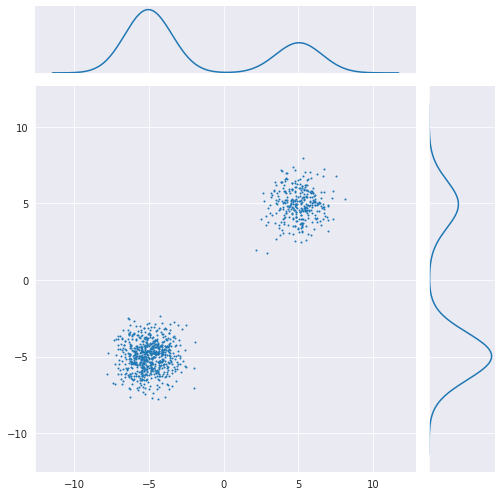

In [4]:
import seaborn as sns  # pip install seaborn

x = pmc.results['samples']
g = sns.JointGrid(height=7)
g.ax_joint.scatter(x[:, 0], x[:, 1], s=1.0)
sns.kdeplot(x=x[:, 0], ax=g.ax_marg_x)
sns.kdeplot(y=x[:, 1], ax=g.ax_marg_y)
plt.show()

The trace plot shows PMC evolves the particles in each dimension.

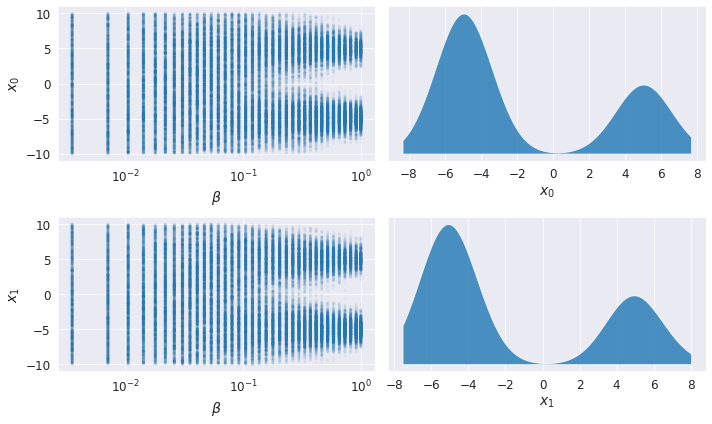

In [5]:
pc.plotting.trace(pmc.results, dims=[0, 1])
plt.show()

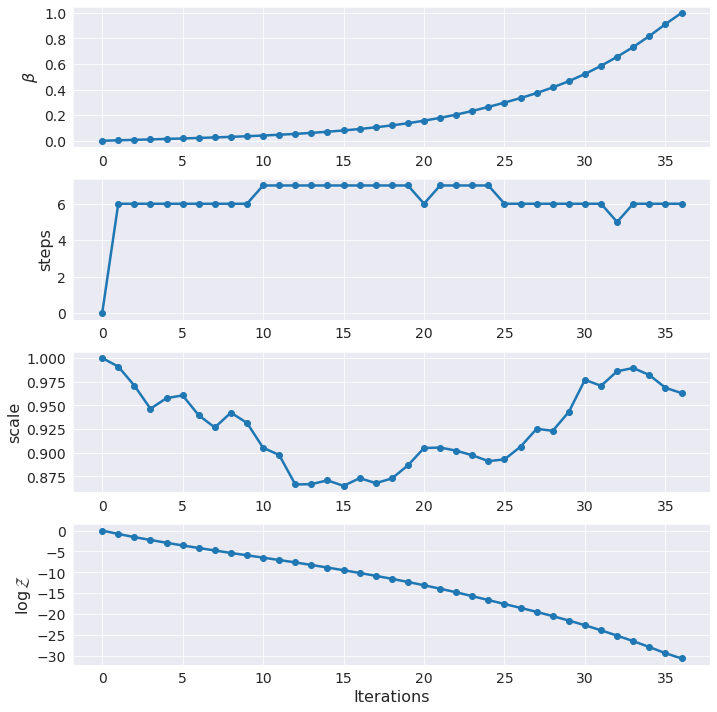

In [6]:
pc.plotting.run(pmc.results)
plt.show()